In [1]:
import torch
from torch import nn

In [2]:
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "PlantVillageDataset"

In [3]:
# setting up our training and testing paths.
train_dir = image_path / "train"
test_dir = image_path / "test"

In [4]:
train_dir,test_dir

(WindowsPath('data/PlantVillageDataset/train'),
 WindowsPath('data/PlantVillageDataset/test'))

In [5]:
from utils import walkthrough_dir
walkthrough_dir(image_path)

There are 2 directories and 0 images in data\PlantVillageDataset
There are 10 directories and 0 images in data\PlantVillageDataset\test
There are 0 directories and 426 images in data\PlantVillageDataset\test\Tomato_Bacterial_spot
There are 0 directories and 200 images in data\PlantVillageDataset\test\Tomato_Early_blight
There are 0 directories and 319 images in data\PlantVillageDataset\test\Tomato_healthy
There are 0 directories and 382 images in data\PlantVillageDataset\test\Tomato_Late_blight
There are 0 directories and 191 images in data\PlantVillageDataset\test\Tomato_Leaf_Mold
There are 0 directories and 355 images in data\PlantVillageDataset\test\Tomato_Septoria_leaf_spot
There are 0 directories and 336 images in data\PlantVillageDataset\test\Tomato_Spider_mites_Two_spotted_spider_mite
There are 0 directories and 281 images in data\PlantVillageDataset\test\Tomato__Target_Spot
There are 0 directories and 75 images in data\PlantVillageDataset\test\Tomato__Tomato_mosaic_virus
There 

Random image path: data\PlantVillageDataset\train\Tomato_Septoria_leaf_spot\de026b6e-618a-4d24-8e9a-511144aa94d9___Matt.S_CG 0915.JPG
Image class: Tomato_Septoria_leaf_spot
Image height: 256
Image width: 256


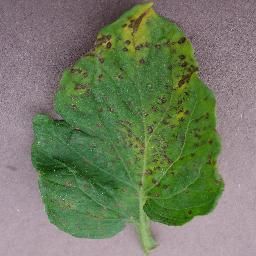

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

### Loading Image data Using ImageFolder


In [7]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,transform = None,target_transform = None)
test_data = datasets.ImageFolder(root = test_dir, transform = None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 12804
     Root location: data\PlantVillageDataset\train,
 Dataset ImageFolder
     Number of datapoints: 3207
     Root location: data\PlantVillageDataset\test)

In [8]:
class_names = train_data.classes
class_names


['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
import matplotlib.pyplot as plt

In [10]:
# Augment train data
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [11]:
# 1. Load and transform data
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 16 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1ca0d3a7cb0>,
 <torch.utils.data.dataloader.DataLoader at 0x1ca0bb1e9c0>)

In [12]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [13]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
  )
)

In [14]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

KeyboardInterrupt: 

In [15]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [16]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\Acer nitro\Desktop\plant-disease-classification\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# # Set random seeds
# torch.manual_seed(42) 
# torch.cuda.manual_seed(42)

# # Set number of epochs
# NUM_EPOCHS = 5

# # Recreate an instance of TinyVGG
# model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
#                   hidden_units=10, 
#                   output_shape=len(train_data.classes)).to(device)

# # Setup loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# # Start the timer
# from timeit import default_timer as timer 
# start_time = timer()

# # Train model_0 
# model_0_results = train(model=model_0, 
#                         train_dataloader=train_dataloader,
#                         test_dataloader=test_dataloader,
#                         optimizer=optimizer,
#                         loss_fn=loss_fn, 
#                         epochs=NUM_EPOCHS)

# # End the timer and print out how long it took
# end_time = timer()
# print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [122]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FB54A167A0>
Traceback (most recent call last):
  File "c:\Users\Acer nitro\Desktop\plant-disease-classification\env\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\Acer nitro\Desktop\plant-disease-classification\env\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


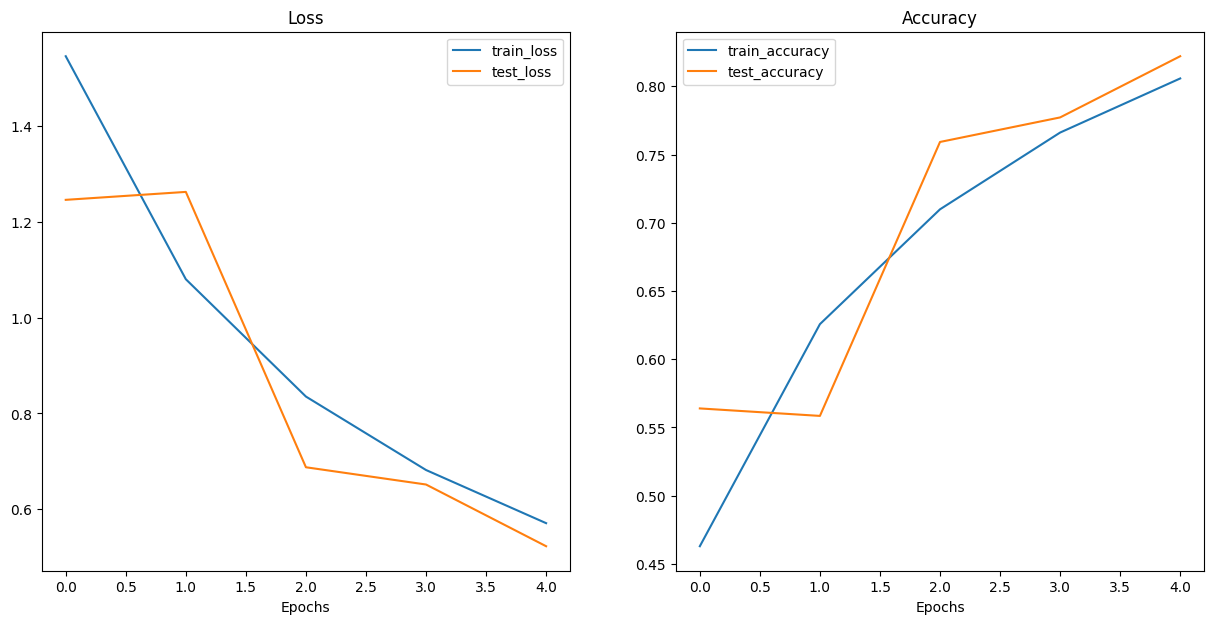

In [123]:
plot_loss_curves(results=model_0_results)

### VGG-11 model

In [23]:
class VGG(nn.Module):
    def __init__(self,input_shape):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                kernel_size=3,
                padding=1,
                out_channels=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                kernel_size=3,
                padding=1,
                out_channels=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                kernel_size=3,
                padding=1,
                out_channels=256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                kernel_size=3,
                padding=1,
                out_channels=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                kernel_size=3,
                padding=1,
                out_channels=512),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                kernel_size=3,
                padding=1,
                out_channels=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                kernel_size=3,
                padding=1,
                out_channels=512),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                kernel_size=3,
                padding=1,
                out_channels=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=2*2*512,out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096,out_features=len(class_names))
            )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.classifier(x)
        return x
        

In [24]:
model_VGG = VGG(input_shape=3)

In [25]:
from torchinfo import summary
summary(model_VGG, input_size=[1, 3, 64, 64])

c:\Users\Acer nitro\Desktop\plant-disease-classification\env\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           1,792
│    └─ReLU: 2-2                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-3                    [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-4                       [1, 128, 32, 32]          73,856
│    └─ReLU: 2-5                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-6                    [1, 128, 16, 16]          --
├─Sequential: 1-3                        [1, 256, 8, 8]            --
│    └─Conv2d: 2-7                       [1, 256, 16, 16]          295,168
│    └─ReLU: 2-8                         [1, 256, 16, 16]          --
│    └─Conv2d: 2-9                       [1, 256, 16, 16]          590,08